<a href="https://colab.research.google.com/github/dmlcks123/gptforecondata/blob/main/9%EC%B0%A8_%EA%B2%BD%EC%A0%9C%EC%A7%80%ED%91%9C_%EB%B6%84%EC%84%9D_ver_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 주요 경제지표 분석
- 이 장에서는 우리나라의 경제 상황을 확인 할 수 있는 주요 경제지표를 수집하고, 그래프를 통해 여러 경제지표를 동시에 비교하는 방법을 습득하고자 함
- 또한 최근 텍스트 마이닝을 통한 경제지표 개발 사례를 살펴보고, 앞서 학습한 크롤링, 텍스트 분석을 활용해 텍스트 마이닝을 통한 경제지표를 개발하는 실습을 진행하고자 함

# 경제지표의 정의
- 경제력 혹은 국민의 생활 수준 등 경제활동 상황을 나타내는 다양한 형태의 지표로 대표적으로 국태총생산(GDP), 고용률, 실업률 등이 있음

## 경제지표의 구분
- 경제지표는 각 지표가 나타내는 경제활동 상황과 특성에 따라 다양하게 구분이 가능함
- 한국은행에서 주기적으로 발간하는 알기 쉬운 경제지표해설에서는 크게는 "실물, 고용 및 기업경영 지표", "금융, 물가 및 재정지표", "대외거래지표"로 구분하고 있음
- 각 지표는 경기동향을 예측하는데 사용되는 선행지표, 현재의 경기 상황을 나타내는 동행지표, 경기의 변동을 사후적으로 확인하는 후행지표로 구분하기도 함
    - 대표적인 선행지표로는 구인구직비율, 건설수주액, 재고순환지표 등이 있으며, 경기 동향을 예측하는 9개 지수를 종합하여 선행종합지수를 작성함
    - 동행지표로는 광공업생산지수, 소매판매액지수, 비농림어업취업자수가 있으며, 7개 지표로 구성된 동행종합지수를 작성함
    - 후행지표는 생산자제품재고지수, 회사채유통수익률, 가계소비지출이 있으며, 5개 지표로 후행종합지수를 산정함

## 경제지표 수집

- 경제지표는 다양한 기관에서 발표하고 있으며, 잘 알려진 지표는 보통 통계청이나 한국은행 등에서 쉽게 구할 수 있음

#### 다운로드
- 아래 url에 접근하면 원자료가 입력된 엑셀 혹은 각 사이트에서 제공하는 그래프를 그림파일 형태로 내려받을 수 있음
    - 한국은행 100대 통계지표: https://ecos.bok.or.kr/#/StatisticsByTheme/KoreanStat100
    - KOSIS 100대 지표: https://kosis.kr/visual/nsportalStats/main.do
    - KDI 경제정보센터 경제지표: https://eiec.kdi.re.kr/bigdata/indicators.do

#### OpenAPI
- 통계청: 통계청에서 원하는 통계를 검색 후 세부 설정을 마친 뒤 OPENAPI를 클릭하면 설정된 페이지 형태로 데이터를 얻을 수 있는 주소를 알려줌
    - 조회량을 적게 한 뒤 조회된 내용과 url을 ChatGPT에 입력하고 Dataframe을 생성해 달라는 내용을 전달하면 분석에 필요한 데이터를 확보 가능함
    - 아래는 경제심리지수

In [ ]:
import requests
import pandas as pd

# URL of the API
url = "https://kosis.kr/openapi/Param/statisticsParameterData.do?method=getList&apiKey=ZDE3ZTViNDMwNGJmZDU4YzgyMjE2Nzk2ZTIyNjcwMGY=&itmId=T1+&objL1=A01+B02+C03+&objL2=&objL3=&objL4=&objL5=&objL6=&objL7=&objL8=&format=json&jsonVD=Y&prdSe=M&newEstPrdCnt=60&outputFields=NM_ENG+PRD_DE+&orgId=101&tblId=DT_1C8016"

# Call the API
response = requests.get(url)
data = response.json()

# Convert JSON response to DataFrame
df = pd.DataFrame(data)

# Pivoting the DataFrame to wide form
df_kosis = df.pivot(index='PRD_DE', columns='C1_NM_ENG', values='DT').reset_index()

df_kosis = df_kosis.rename(columns={' Composite Coincident Index (2020＝100)': 'Coincident_Index',
                                    ' Composite Lagging Index  (2020＝100)': 'Lagging_Index',
                                    ' Composite Leading Index (2020＝100)': 'Leading_Index'})

df_kosis.head()

C1_NM_ENG,PRD_DE,Coincident_Index,Lagging_Index,Leading_Index
0,201906,99.5,97.8,95.7
1,201907,99.7,98,95.7
2,201908,100,98.3,95.9
3,201909,100.3,98.6,96.2
4,201910,100.5,98.7,96.8


- OECD는 별도의 가입절차 없이 OPENAPI를 제공함

In [ ]:
#| echo: true
#| code-fold: true
#| code-summary: "expand for full code"
import requests
import xml.etree.ElementTree as ET
import pandas as pd

# API URL
url = "https://sdmx.oecd.org/public/rest/data/OECD.SDD.TPS,DSD_LFS@DF_IALFS_UNE_M,1.0/OECD+KOR..._Z.Y._T.Y_GE15..M?startPeriod=2020-04"

# API 호출
response = requests.get(url)

# XML 파싱
root = ET.fromstring(response.content)

# 데이터를 저장할 리스트 초기화
data = []

# XML에서 데이터 추출
for series in root.findall('.//generic:Series', namespaces={'generic': 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/data/generic'}):
    ref_area = series.find('./generic:SeriesKey/generic:Value[@id="REF_AREA"]', namespaces={'generic': 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/data/generic'}).attrib['value']
    measure = series.find('./generic:SeriesKey/generic:Value[@id="MEASURE"]', namespaces={'generic': 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/data/generic'}).attrib['value']
    unit_measure = series.find('./generic:SeriesKey/generic:Value[@id="UNIT_MEASURE"]', namespaces={'generic': 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/data/generic'}).attrib['value']
    transformation = series.find('./generic:SeriesKey/generic:Value[@id="TRANSFORMATION"]', namespaces={'generic': 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/data/generic'}).attrib['value']
    adjustment = series.find('./generic:SeriesKey/generic:Value[@id="ADJUSTMENT"]', namespaces={'generic': 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/data/generic'}).attrib['value']
    sex = series.find('./generic:SeriesKey/generic:Value[@id="SEX"]', namespaces={'generic': 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/data/generic'}).attrib['value']
    age = series.find('./generic:SeriesKey/generic:Value[@id="AGE"]', namespaces={'generic': 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/data/generic'}).attrib['value']
    activity = series.find('./generic:SeriesKey/generic:Value[@id="ACTIVITY"]', namespaces={'generic': 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/data/generic'}).attrib['value']
    freq = series.find('./generic:SeriesKey/generic:Value[@id="FREQ"]', namespaces={'generic': 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/data/generic'}).attrib['value']

    for obs in series.findall('.//generic:Obs', namespaces={'generic': 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/data/generic'}):
        time_period = obs.find('./generic:ObsDimension', namespaces={'generic': 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/data/generic'}).attrib['value']
        value = obs.find('./generic:ObsValue', namespaces={'generic': 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/data/generic'}).attrib['value']
        obs_status = obs.find('./generic:Attributes/generic:Value[@id="OBS_STATUS"]', namespaces={'generic': 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/data/generic'}).attrib['value']

        # 데이터를 리스트에 추가
        data.append({
            "TIME_PERIOD": time_period,
            "REF_AREA": ref_area,
            "MEASURE": measure,
            "UNIT_MEASURE": unit_measure,
            "TRANSFORMATION": transformation,
            "ADJUSTMENT": adjustment,
            "SEX": sex,
            "AGE": age,
            "ACTIVITY": activity,
            "FREQ": freq,
            "VALUE": float(value),
            "OBS_STATUS": obs_status
        })

# DataFrame 생성
df_oecd = pd.DataFrame(data)

# 데이터프레임 출력
df_oecd.head()

,TIME_PERIOD,REF_AREA,MEASURE,UNIT_MEASURE,TRANSFORMATION,ADJUSTMENT,SEX,AGE,ACTIVITY,FREQ,VALUE,OBS_STATUS
0,2020-11,OECD,UNE_LF_M,PT_LF_SUB,_Z,Y,_T,Y_GE15,_Z,M,6.916832,E
1,2020-12,OECD,UNE_LF_M,PT_LF_SUB,_Z,Y,_T,Y_GE15,_Z,M,6.862576,E
2,2020-06,OECD,UNE_LF_M,PT_LF_SUB,_Z,Y,_T,Y_GE15,_Z,M,8.323464,E
3,2020-07,OECD,UNE_LF_M,PT_LF_SUB,_Z,Y,_T,Y_GE15,_Z,M,8.175251,E
4,2020-08,OECD,UNE_LF_M,PT_LF_SUB,_Z,Y,_T,Y_GE15,_Z,M,7.581923,E


#### 실업률과 경기종합지수
- 두 데이터 프레임을 병합

In [ ]:
# 필요한 컬럼만 선택
df_oecd_1 = df_oecd[['TIME_PERIOD', 'REF_AREA', 'VALUE']]

# REF_AREA를 구분자로 사용하여 long 타입으로 reshape
df_oecd_long = df_oecd_1.pivot(index='TIME_PERIOD', columns='REF_AREA', values='VALUE').reset_index()

# 날짜 구조를 통계청과 일원화
df_oecd_long['TIME_PERIOD'] = df_oecd_long['TIME_PERIOD'].str.replace('-', '')

df_oecd_long = df_oecd_long[['TIME_PERIOD', 'KOR', 'OECD']]

df_oecd_long.head()


REF_AREA,TIME_PERIOD,KOR,OECD
0,202004,3.9,8.831954
1,202005,4.4,8.673325
2,202006,4.2,8.323464
3,202007,4.1,8.175251
4,202008,3.7,7.581923


### 경제지표 간 그래프를 이용한 비교
#### 실업률과 경기 선행, 후행, 동행

- 두 데이터 프레임을 병합

In [ ]:
merged_df = pd.merge(df_kosis, df_oecd_long, left_on='PRD_DE', right_on='TIME_PERIOD', how='inner')
merged_df = merged_df.drop(columns=['TIME_PERIOD'])
merged_df.head()

,PRD_DE,Coincident_Index,Lagging_Index,Leading_Index,KOR,OECD
0,202004,99.1,99.4,98.5,3.9,8.831954
1,202005,98.2,99.5,98.5,4.4,8.673325
2,202006,98.5,99.7,99,4.2,8.323464
3,202007,98.8,99.9,99.6,4.1,8.175251
4,202008,99.4,100.2,100.4,3.7,7.581923


In [ ]:
merged_df.describe()

,KOR,OECD
count,50.00000,50.000000
mean,3.22000,5.732222
std,0.61611,1.164762
min,2.50000,4.789814
25%,2.80000,4.885422
50%,2.95000,5.007691
75%,3.77500,6.614204
max,4.80000,8.831954


In [ ]:
# 문자열을 숫자로 변환
merged_df['Coincident_Index'] = pd.to_numeric(merged_df['Coincident_Index'], errors='coerce')
merged_df['Lagging_Index'] = pd.to_numeric(merged_df['Lagging_Index'], errors='coerce')
merged_df['Leading_Index'] = pd.to_numeric(merged_df['Leading_Index'], errors='coerce')

merged_df.describe()

,Coincident_Index,Lagging_Index,Leading_Index,KOR,OECD
count,50.000000,50.000000,50.000000,50.00000,50.000000
mean,106.432000,107.804000,107.748000,3.22000,5.732222
std,4.274148,5.443699,4.334354,0.61611,1.164762
min,98.200000,99.400000,98.500000,2.50000,4.789814
25%,103.275000,102.800000,105.975000,2.80000,4.885422
50%,107.500000,108.000000,108.200000,2.95000,5.007691
75%,110.250000,113.150000,109.750000,3.77500,6.614204
max,112.000000,115.200000,115.100000,4.80000,8.831954


## 선행, 후행, 동행지표와 실업률 - 스캐터그램

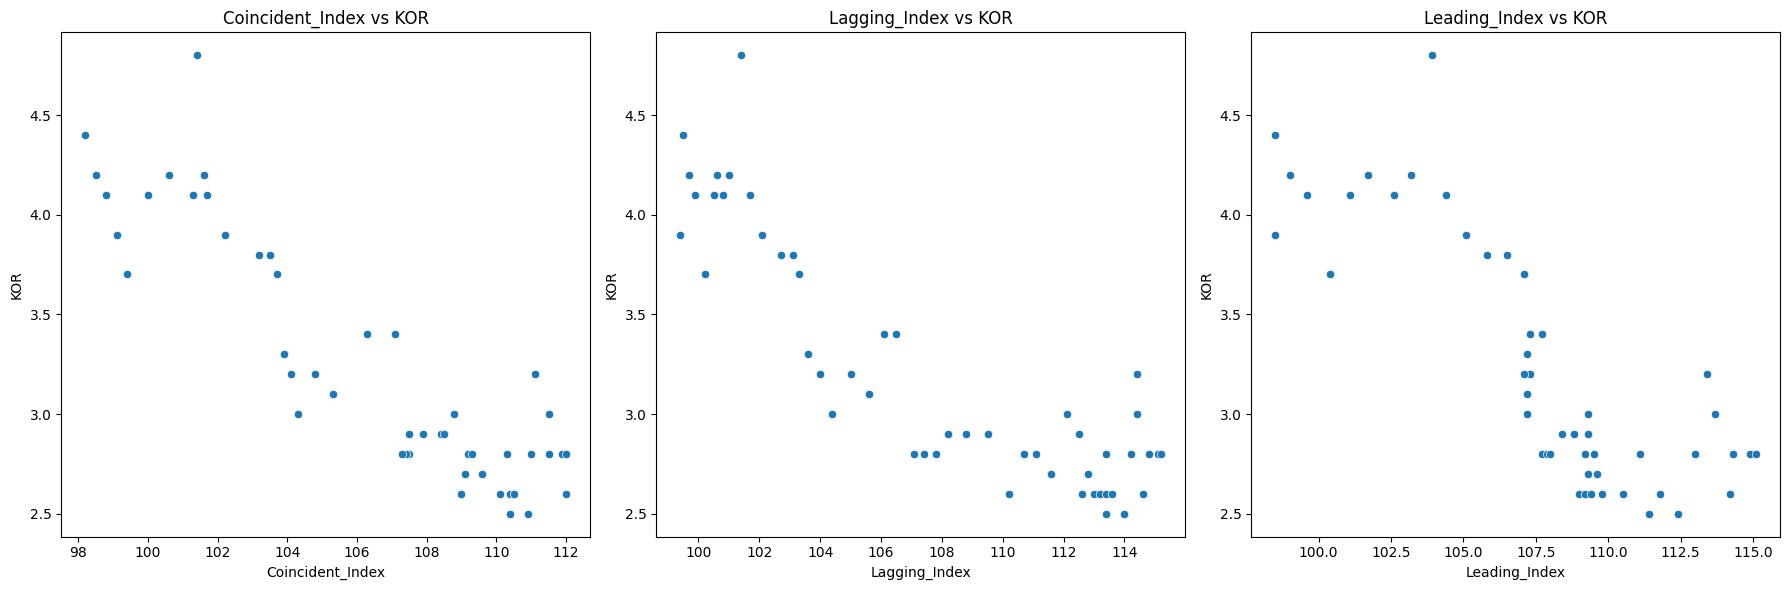

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 그래프 그리기
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Coincident_Index vs KOR
sns.scatterplot(x='Coincident_Index', y='KOR', data=merged_df, ax=axes[0])
axes[0].set_title('Coincident_Index vs KOR')

# Lagging_Index vs KOR
sns.scatterplot(x='Lagging_Index', y='KOR', data=merged_df, ax=axes[1])
axes[1].set_title('Lagging_Index vs KOR')

# Leading_Index vs KOR
sns.scatterplot(x='Leading_Index', y='KOR', data=merged_df, ax=axes[2])
axes[2].set_title('Leading_Index vs KOR')

# 레이아웃 조정
plt.tight_layout()
plt.show()

## 선행, 후행, 동행지표와 실업률 - 선형그래프(1)

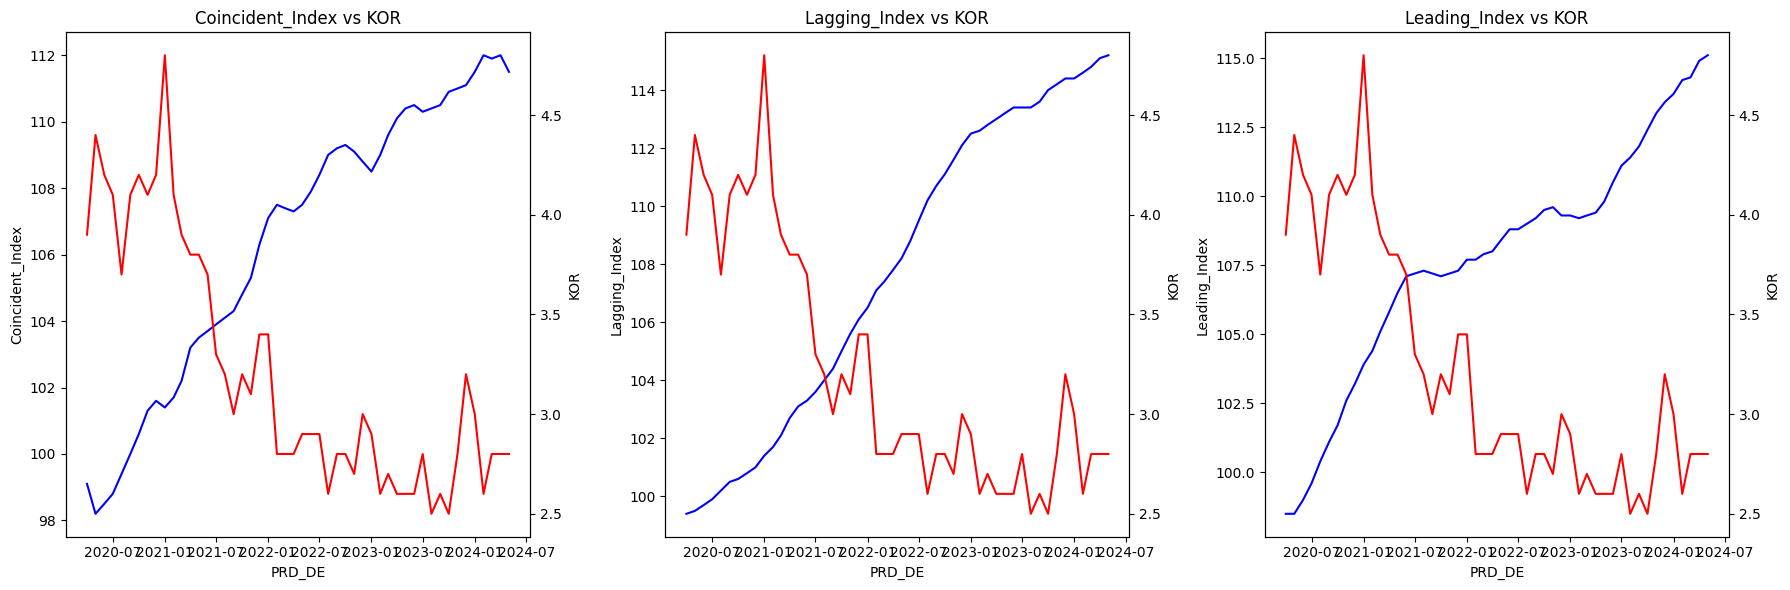

In [ ]:
# PRD_DE 변수를 날짜 형식으로 변환
merged_df['PRD_DE'] = pd.to_datetime(merged_df['PRD_DE'], format='%Y%m')

# 그래프 그리기
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Coincident_Index vs KOR
ax1 = axes[0]
ax2 = ax1.twinx()
sns.lineplot(x='PRD_DE', y='Coincident_Index', data=merged_df, ax=ax1, color='b')
sns.lineplot(x='PRD_DE', y='KOR', data=merged_df, ax=ax2, color='r')
ax1.set_title('Coincident_Index vs KOR')
ax1.set_ylabel('Coincident_Index')
ax2.set_ylabel('KOR')

# Lagging_Index vs KOR
ax3 = axes[1]
ax4 = ax3.twinx()
sns.lineplot(x='PRD_DE', y='Lagging_Index', data=merged_df, ax=ax3, color='b')
sns.lineplot(x='PRD_DE', y='KOR', data=merged_df, ax=ax4, color='r')
ax3.set_title('Lagging_Index vs KOR')
ax3.set_ylabel('Lagging_Index')
ax4.set_ylabel('KOR')

# Leading_Index vs KOR
ax5 = axes[2]
ax6 = ax5.twinx()
sns.lineplot(x='PRD_DE', y='Leading_Index', data=merged_df, ax=ax5, color='b')
sns.lineplot(x='PRD_DE', y='KOR', data=merged_df, ax=ax6, color='r')
ax5.set_title('Leading_Index vs KOR')
ax5.set_ylabel('Leading_Index')
ax6.set_ylabel('KOR')

# 레이아웃 조정
plt.tight_layout()
plt.show()

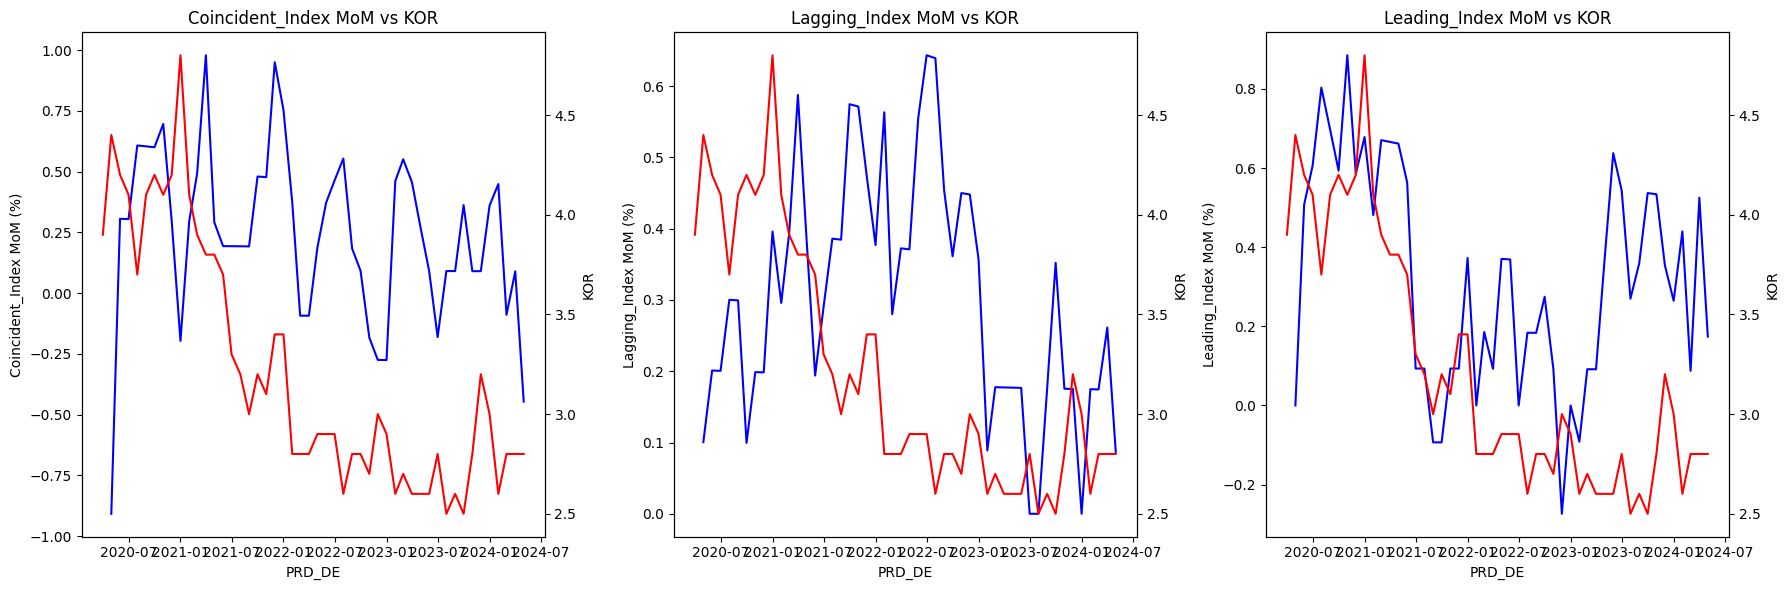

In [ ]:
# 전월대비 변동률 계산 함수
def calc_monthly_change(df, column):
    df[f'{column}_MoM'] = df[column].pct_change() * 100

# 변동률 계산
calc_monthly_change(merged_df, 'Coincident_Index')
calc_monthly_change(merged_df, 'Lagging_Index')
calc_monthly_change(merged_df, 'Leading_Index')

# 그래프 그리기
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Coincident_Index_MoM vs KOR
ax1 = axes[0]
ax2 = ax1.twinx()
sns.lineplot(x='PRD_DE', y='Coincident_Index_MoM', data=merged_df, ax=ax1, color='b')
sns.lineplot(x='PRD_DE', y='KOR', data=merged_df, ax=ax2, color='r')
ax1.set_title('Coincident_Index MoM vs KOR')
ax1.set_ylabel('Coincident_Index MoM (%)')
ax2.set_ylabel('KOR')

# Lagging_Index_MoM vs KOR
ax3 = axes[1]
ax4 = ax3.twinx()
sns.lineplot(x='PRD_DE', y='Lagging_Index_MoM', data=merged_df, ax=ax3, color='b')
sns.lineplot(x='PRD_DE', y='KOR', data=merged_df, ax=ax4, color='r')
ax3.set_title('Lagging_Index MoM vs KOR')
ax3.set_ylabel('Lagging_Index MoM (%)')
ax4.set_ylabel('KOR')

# Leading_Index_MoM vs KOR
ax5 = axes[2]
ax6 = ax5.twinx()
sns.lineplot(x='PRD_DE', y='Leading_Index_MoM', data=merged_df, ax=ax5, color='b')
sns.lineplot(x='PRD_DE', y='KOR', data=merged_df, ax=ax6, color='r')
ax5.set_title('Leading_Index MoM vs KOR')
ax5.set_ylabel('Leading_Index MoM (%)')
ax6.set_ylabel('KOR')

# 레이아웃 조정
plt.tight_layout()
plt.show()

## 산업생산지수와 실업률

In [ ]:
import requests
import pandas as pd

# URL of the API
url = "https://kosis.kr/openapi/Param/statisticsParameterData.do?method=getList&apiKey=ZDE3ZTViNDMwNGJmZDU4YzgyMjE2Nzk2ZTIyNjcwMGY=&itmId=T1+&objL1=ALL&objL2=&objL3=&objL4=&objL5=&objL6=&objL7=&objL8=&format=json&jsonVD=Y&prdSe=M&newEstPrdCnt=60&outputFields=NM_ENG+PRD_DE+&orgId=101&tblId=DT_1JH20202"

# Call the API
response = requests.get(url)
data = response.json()

# Convert JSON response to DataFrame
df = pd.DataFrame(data)

# 1. 날짜 형식 변환
df['PRD_DE'] = pd.to_datetime(df['PRD_DE'].astype(str) + '01', format='%Y%m%d')

# 'DT' 열을 숫자형으로 변환
df['DT'] = pd.to_numeric(df['DT'])

# 2. 전년동월대비 증감률 계산
df['Previous_Year'] = df['PRD_DE'] - pd.DateOffset(years=1)
df = df.merge(df[['PRD_DE', 'C1_NM_ENG', 'DT']].rename(columns={'PRD_DE': 'Previous_Year', 'DT': 'Previous_DT'}),
              on=['Previous_Year', 'C1_NM_ENG'], how='left')
df['YoY_Change'] = (df['DT'] - df['Previous_DT']) / df['Previous_DT'] * 100

# 3. 3개월 이동평균 계산
df['YoY_Change_MA'] = df.groupby('C1_NM_ENG')['YoY_Change'].transform(lambda x: x.rolling(window=3).mean())

# 필요한 열만 선택하여 정리
result = df[['PRD_DE', 'C1_NM_ENG', 'DT', 'YoY_Change', 'YoY_Change_MA']]

result.tail()

,PRD_DE,C1_NM_ENG,DT,YoY_Change,YoY_Change_MA
295,2024-01-01,Public administration,106.1,2.611219,-7.419888
296,2024-02-01,Public administration,107.5,-0.185701,-2.172755
297,2024-03-01,Public administration,105.7,-4.343891,-0.639458
298,2024-04-01,Public administration,104.8,4.695305,0.055237
299,2024-05-01,Public administration,107.1,1.324503,0.558639


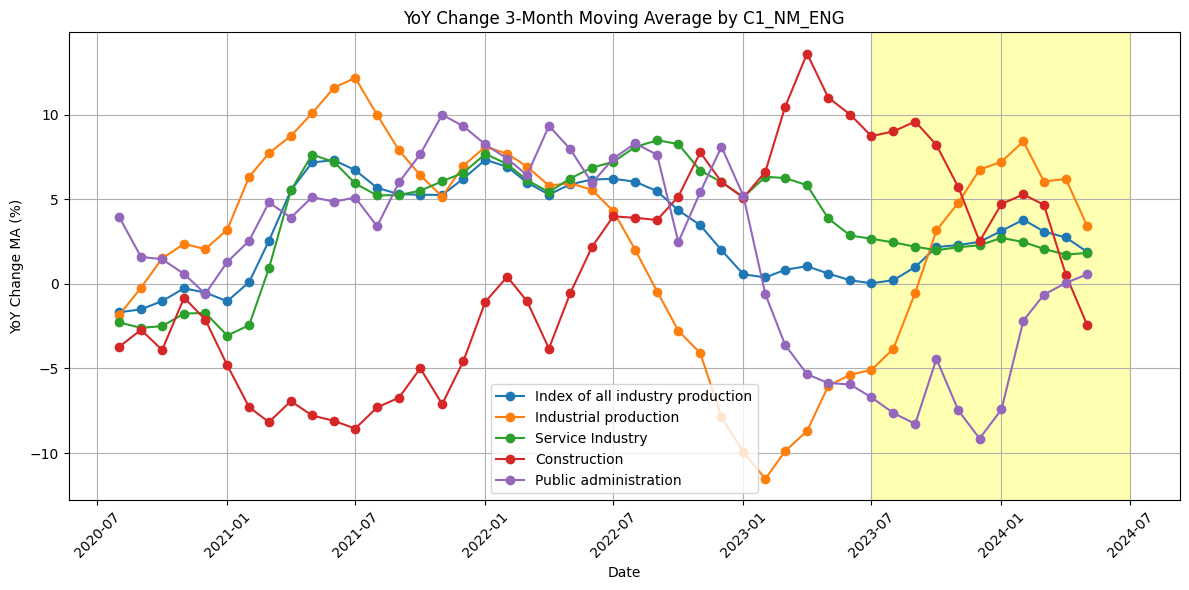

In [ ]:
# 그래프 그리기
plt.figure(figsize=(12, 6))

for c1_nm_eng in result['C1_NM_ENG'].unique():
    subset = result[result['C1_NM_ENG'] == c1_nm_eng]
    plt.plot(subset['PRD_DE'], subset['YoY_Change_MA'], marker='o', label=c1_nm_eng)

# 특정 구간 배경 색 설정
plt.axvspan(pd.to_datetime('2023-07-01'), pd.to_datetime('2024-06-30'), color='yellow', alpha=0.3)

plt.xlabel('Date')
plt.ylabel('YoY Change MA (%)')
plt.title('YoY Change 3-Month Moving Average by C1_NM_ENG')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# 그래프 보여주기
plt.show()

### 최근 1년만 그리기

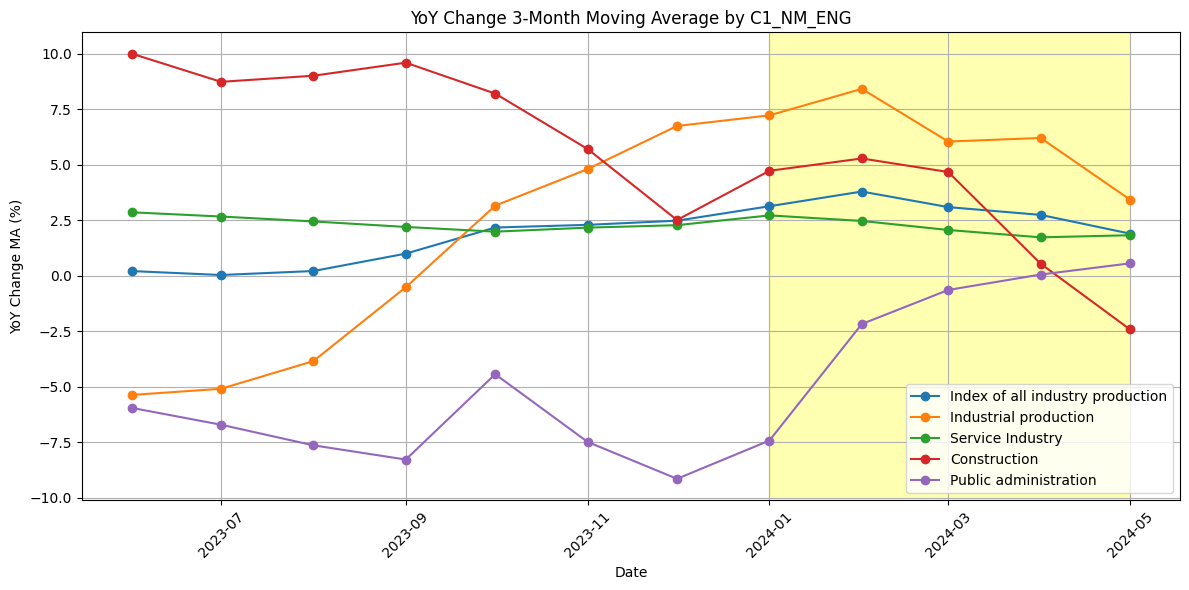

In [ ]:
# 특정 기간 필터링 (2023년 7월 1일부터 2024년 6월 30일까지)
start_date = pd.to_datetime('2023-06-01')
end_date = pd.to_datetime('2024-05-01')
filtered_result = result[(result['PRD_DE'] >= start_date) & (result['PRD_DE'] <= end_date)]

# 그래프 그리기
plt.figure(figsize=(12, 6))

for c1_nm_eng in filtered_result['C1_NM_ENG'].unique():
    subset = filtered_result[filtered_result['C1_NM_ENG'] == c1_nm_eng]
    plt.plot(subset['PRD_DE'], subset['YoY_Change_MA'], marker='o', label=c1_nm_eng)

# 특정 구간 배경 색 설정
plt.axvspan(pd.to_datetime('2024-01-01'), pd.to_datetime('2024-05-01'), color='yellow', alpha=0.3)

plt.xlabel('Date')
plt.ylabel('YoY Change MA (%)')
plt.title('YoY Change 3-Month Moving Average by C1_NM_ENG')
plt.legend()  # 범례 표시
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# 그래프 보여주기
plt.show()

- 광공업 생산은 2023년 하반기 이후 회복되는 모습을 보였으며, 4월 이후 회복세가 다소 둔화되는 모습을 나타냄
- 건설업은 2024년 12월까지 생산이 둔화되는 모습을 보이다 2024년 초 다소 회복되는 모습을 보이다 2024년 3월 이후 하락세를 나타냄

## 텍스트 마이닝을 이용한 경제지표 개발 사례 - 뉴스심리지수

[기계학습을 이용한 뉴스심리지수(NSI)의 작성과 활용](https://www.bok.or.kr/portal/bbs/B0000233/view.do?nttId=10070681&menuNo=200707)

한국은행 경제통계국은 경제분야 뉴스기사에 나타나는 경제심리를 지수화한 뉴스 심리지수(NSI, News Sentiment Index)를 개발하여 2022년 2월부터 매주 한국은행 경제 통계시스템(ECOS)에 실험적 통계로 공개하고 있다. 뉴스심리지수는 인터넷 포털사이 트의 경제기사 텍스트를 웹크롤링 기법으로 수집하고 이를 최신 자연어 처리(NLP, Natural Language Processing) 모형으로 분석하여 작성한다.(서범석 외, 2022)


## 필립스 곡선

In [ ]:
import requests
import pandas as pd

# URL of the API
url = "https://kosis.kr/openapi/Param/statisticsParameterData.do?method=getList&apiKey=ZDE3ZTViNDMwNGJmZDU4YzgyMjE2Nzk2ZTIyNjcwMGY=&itmId=T80+&objL1=0+&objL2=&objL3=&objL4=&objL5=&objL6=&objL7=&objL8=&format=json&jsonVD=Y&prdSe=M&newEstPrdCnt=60&outputFields=PRD_DE+&orgId=101&tblId=DT_1DA7001S"

# Call the API
response = requests.get(url)
data = response.json()

# Convert JSON response to DataFrame
unemployment = pd.DataFrame(data)

# 컬럼 이름 변경
unemployment = unemployment.rename(columns={'DT': 'unemployment'})

unemployment.head()

,unemployment,PRD_DE
0,3.9,201907
1,3,201908
2,3.1,201909
3,3,201910
4,3.1,201911


In [ ]:
import requests
import pandas as pd

# URL of the API
url = "https://kosis.kr/openapi/Param/statisticsParameterData.do?method=getList&apiKey=ZDE3ZTViNDMwNGJmZDU4YzgyMjE2Nzk2ZTIyNjcwMGY=&itmId=T02+&objL1=0+&objL2=&objL3=&objL4=&objL5=&objL6=&objL7=&objL8=&format=json&jsonVD=Y&prdSe=M&newEstPrdCnt=60&outputFields=PRD_DE+&orgId=101&tblId=DT_1J22042"

# Call the API
response = requests.get(url)
data = response.json()

# Convert JSON response to DataFrame
cpi = pd.DataFrame(data)

# 컬럼 이름 변경
cpi = cpi.rename(columns={'DT': 'cpi'})

cpi.head()

,cpi,PRD_DE
0,-0.3,201907
1,0.2,201908
2,0.4,201909
3,0.2,201910
4,-0.6,201911


In [ ]:
philips = pd.merge(unemployment, cpi, left_on='PRD_DE', right_on='PRD_DE', how='inner')
philips.head()

,unemployment,PRD_DE,cpi
0,3.9,201907,-0.3
1,3,201908,0.2
2,3.1,201909,0.4
3,3,201910,0.2
4,3.1,201911,-0.6


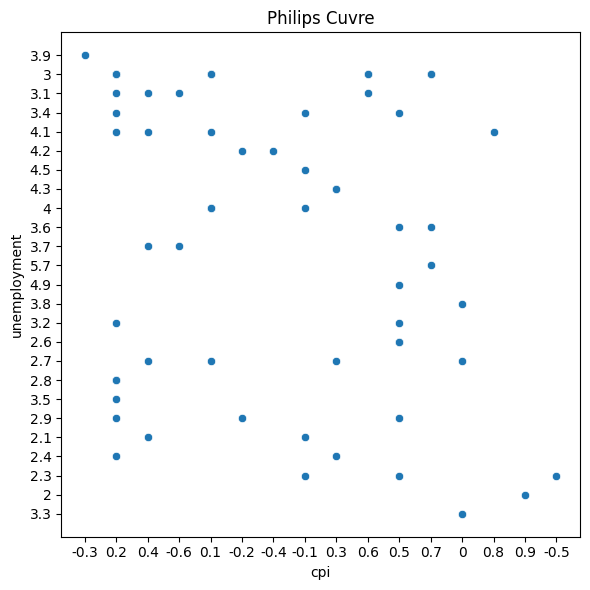

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 그래프 그리기
fig, axes = plt.subplots(1, 1, figsize=(6, 6))

# Coincident_Index vs KOR
sns.scatterplot(x='cpi', y='unemployment', data=philips, ax=axes)
axes.set_title('Philips Cuvre')

# 레이아웃 조정
plt.tight_layout()
plt.show()

In [ ]:
print(philips.dtypes)

unemployment    object
PRD_DE          object
cpi             object
dtype: object


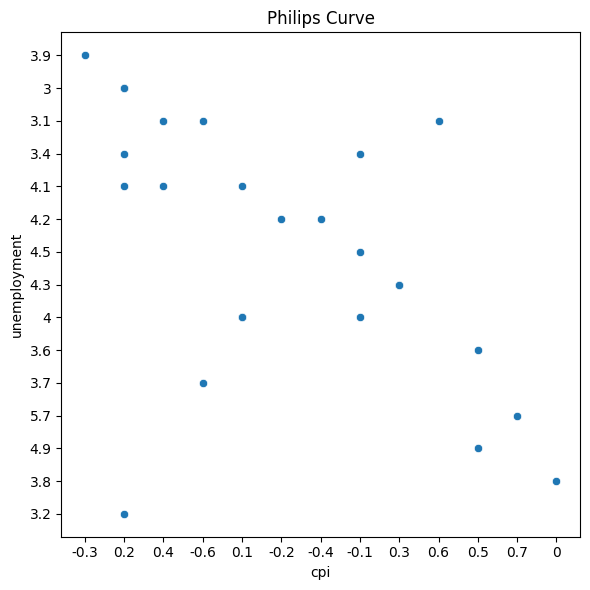

In [ ]:
# PRD_DE를 int 형식으로 변환
philips['PRD_DE'] = philips['PRD_DE'].astype(int)

# 특정 날짜 구간 선택 (201907보다 크거나 같고 202107보다 작거나 같은 경우)
mask = (philips['PRD_DE'] >= 201907) & (philips['PRD_DE'] <= 202107)
filtered_philips = philips[mask]

# 그래프 그리기
fig, ax = plt.subplots(figsize=(6, 6))

# 필터링된 데이터로 스캐터 플롯 그리기
sns.scatterplot(x='cpi', y='unemployment', data=filtered_philips, ax=ax)
ax.set_title('Philips Curve')

# 레이아웃 조정
plt.tight_layout()
plt.show()

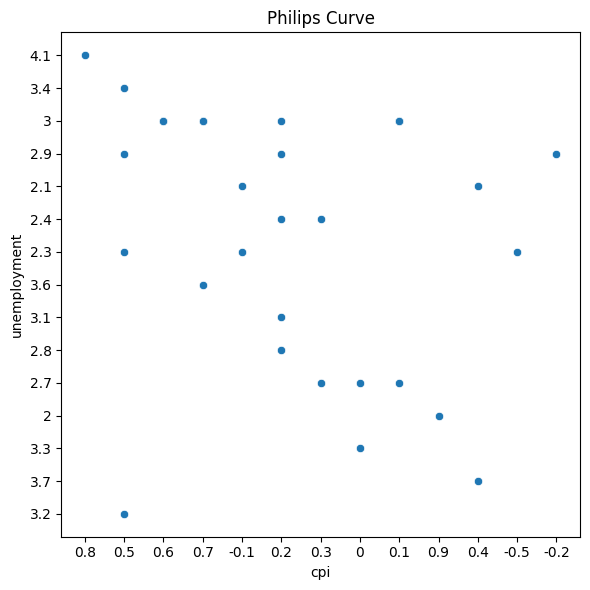

In [ ]:
# PRD_DE를 int 형식으로 변환
philips['PRD_DE'] = philips['PRD_DE'].astype(int)

# 특정 날짜 구간 선택
mask = (philips['PRD_DE'] >= 202201) & (philips['PRD_DE'] <= 202412)
filtered_philips = philips[mask]

# 그래프 그리기
fig, ax = plt.subplots(figsize=(6, 6))

# 필터링된 데이터로 스캐터 플롯 그리기
sns.scatterplot(x='cpi', y='unemployment', data=filtered_philips, ax=ax)
ax.set_title('Philips Curve')

# 레이아웃 조정
plt.tight_layout()
plt.show()

- 종사자규모별 취업자 수(전년동기대비 변화)를 Open API를 활용해 최근 3년간 자료를 분석하시오

In [ ]:
import requests
import pandas as pd

# URL of the API
url = "https://kosis.kr/openapi/Param/statisticsParameterData.do?method=getList&apiKey=ZDE3ZTViNDMwNGJmZDU4YzgyMjE2Nzk2ZTIyNjcwMGY=&itmId=T30+&objL1=10+15+65+&objL2=&objL3=&objL4=&objL5=&objL6=&objL7=&objL8=&format=json&jsonVD=Y&prdSe=M&newEstPrdCnt=36&outputFields=NM_ENG+PRD_DE+&orgId=101&tblId=DT_1DA7A64S"

# Call the API
response = requests.get(url)
data = response.json()

# Convert JSON response to DataFrame
employment = pd.DataFrame(data)

employment.head()

,DT,PRD_DE,C1_NM_ENG
0,10104,202107,1-4 person
1,10047.2,202108,1-4 person
2,10037.3,202109,1-4 person
3,10059.1,202110,1-4 person
4,10009.6,202111,1-4 person


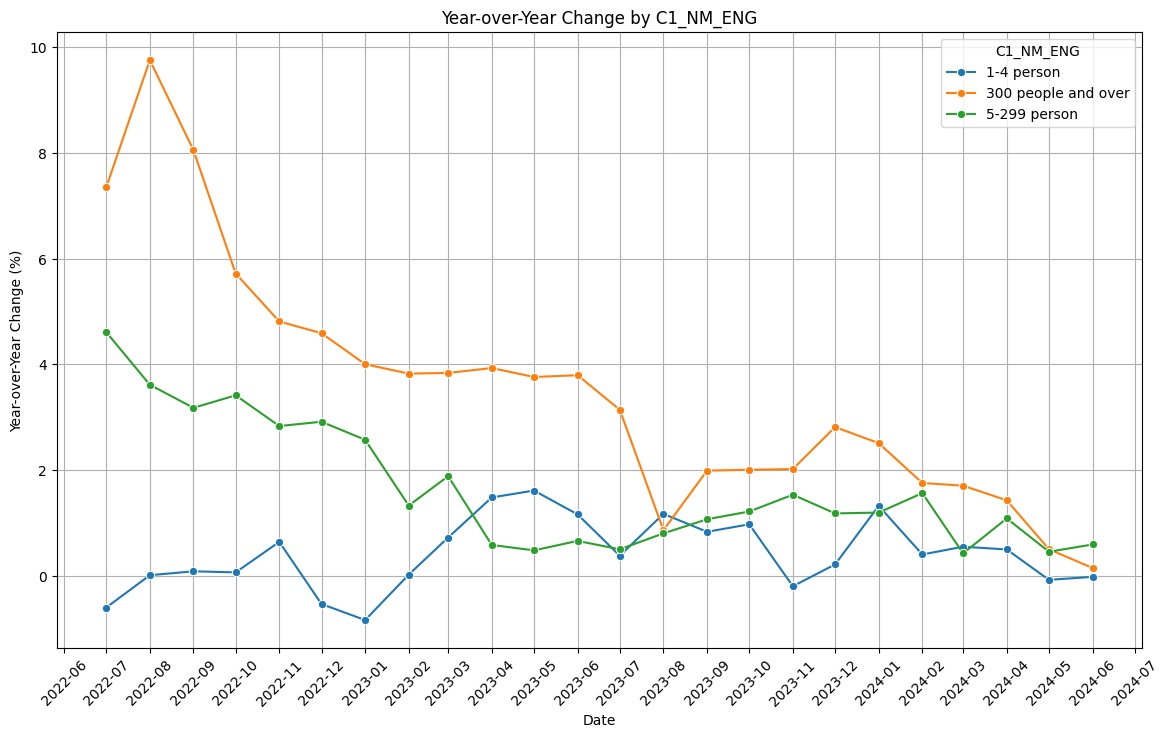

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Assuming you have a DataFrame named 'employment' with columns 'DT', 'PRD_DE', and 'C1_NM_ENG'
# employment = pd.read_csv('your_dataframe.csv')

# Convert 'PRD_DE' to datetime format
employment['PRD_DE'] = pd.to_datetime(employment['PRD_DE'], format='%Y%m')

# Ensure 'DT' is numeric
employment['DT'] = pd.to_numeric(employment['DT'], errors='coerce')

# Sort the dataframe by 'C1_NM_ENG' and 'PRD_DE'
employment = employment.sort_values(by=['C1_NM_ENG', 'PRD_DE'])

# Calculate year-over-year change
employment['YoY_Change'] = employment.groupby('C1_NM_ENG')['DT'].pct_change(periods=12) * 100

# Drop rows with NaN values which are the first year for each C1_NM_ENG
employment = employment.dropna(subset=['YoY_Change'])

# Create the seaborn lineplot
plt.figure(figsize=(14, 8))
sns.lineplot(data=employment, x='PRD_DE', y='YoY_Change', hue='C1_NM_ENG', marker='o')

# Customize the plot
plt.title('Year-over-Year Change by C1_NM_ENG')
plt.xlabel('Date')
plt.ylabel('Year-over-Year Change (%)')
plt.legend(title='C1_NM_ENG')
plt.grid(True)

# Set x-axis major locator to month and formatter to show year and month
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


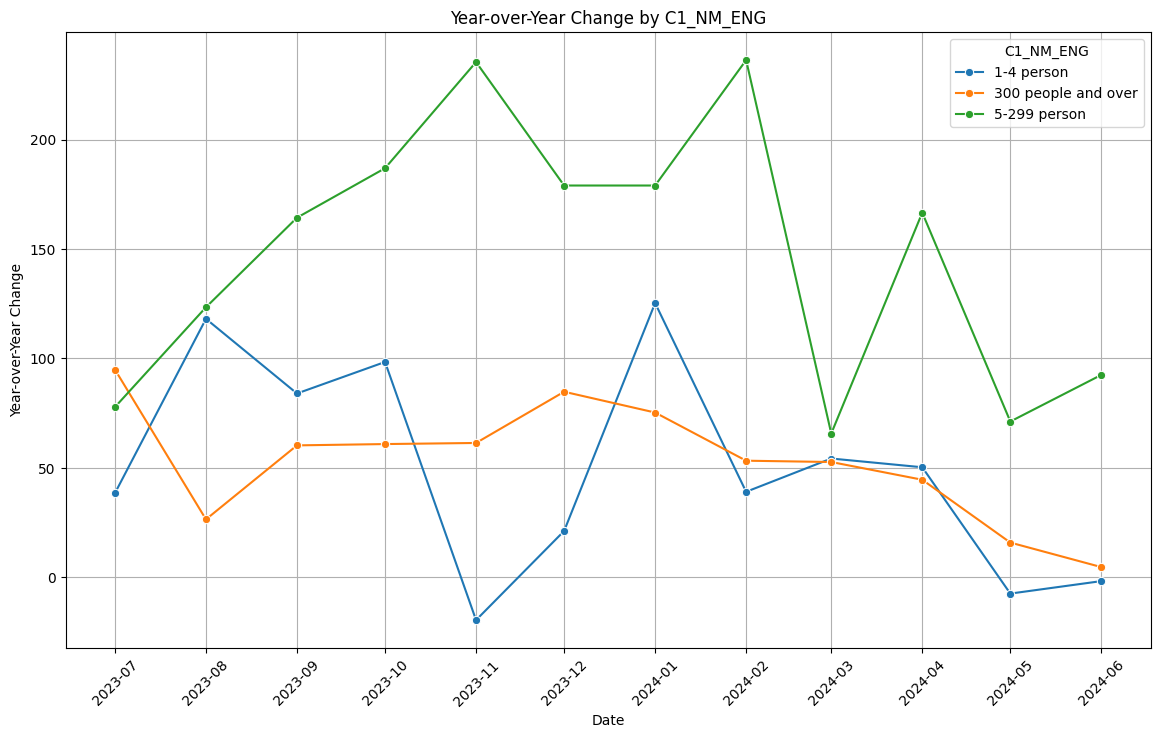

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Assuming you have a DataFrame named 'employment' with columns 'DT', 'PRD_DE', and 'C1_NM_ENG'
# employment = pd.read_csv('your_dataframe.csv')

# Convert 'PRD_DE' to datetime format
employment['PRD_DE'] = pd.to_datetime(employment['PRD_DE'], format='%Y%m')

# Ensure 'DT' is numeric
employment['DT'] = pd.to_numeric(employment['DT'], errors='coerce')

# Sort the dataframe by 'C1_NM_ENG' and 'PRD_DE'
employment = employment.sort_values(by=['C1_NM_ENG', 'PRD_DE'])

# Calculate year-over-year change in value
employment['YoY_Change'] = employment.groupby('C1_NM_ENG')['DT'].diff(periods=12)

# Drop rows with NaN values which are the first year for each C1_NM_ENG
employment = employment.dropna(subset=['YoY_Change'])

# Create the seaborn lineplot
plt.figure(figsize=(14, 8))
sns.lineplot(data=employment, x='PRD_DE', y='YoY_Change', hue='C1_NM_ENG', marker='o')

# Customize the plot
plt.title('Year-over-Year Change by C1_NM_ENG')
plt.xlabel('Date')
plt.ylabel('Year-over-Year Change')
plt.legend(title='C1_NM_ENG')
plt.grid(True)

# Set x-axis major locator to month and formatter to show year and month
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()